Lines in File 10626
Good lines (highest 2 next to each other and in 30-60) 3744
# Photon-Count 27312544
# Matrizes 10626


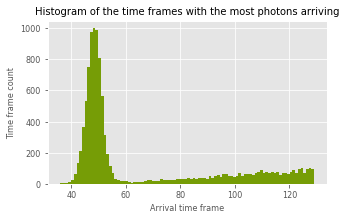

In [27]:
from multiprocessing import Pool
import numpy as np
import operator
import random
import pickle
import gzip
import json
import os

plt.style.use('ggplot')

mc_data_path = '/fhgfs/groups/app/fact/simulated/photon_stream/mc/gammas/diffuse/gamma_gustav_12/'
id_position_path = '/home/jbehnken/07_make_FACT/hexagonal_to_quadratic_mapping_dict.p'
path_build = '/home/jbehnken/07_make_FACT/build/'

def getMetadata():
    '''
    Gathers the file paths of the training data
    '''
    # Iterate over every file in the subdirs and check if it has the right file extension
    file_paths = [os.path.join(dirPath, file) for dirPath, dirName, fileName in os.walk(os.path.expanduser(mc_data_path)) for file in fileName if '.json' in file]
    return file_paths

file_paths = getMetadata()
id_position = pickle.load(open(id_position_path, "rb"))

data = []
num = 0

photons = []
most = []
matricies = []
false_image = []
for path in file_paths[:1]:
    with gzip.open(path) as file:
        # Gamma=True, Proton=False
        label = True if 'gamma' in path else False
        
        lines = 0
        for line in file:
            lines += 1
            event_photons = json.loads(line.decode('utf-8'))['PhotonArrivals_500ps']
            
            event = []
            input_matrix = np.zeros([46,45,100])
            for i in range(1440):
                event.extend(event_photons[i])
                
                x, y = id_position[i]
                for value in event_photons[i]:
                    input_matrix[int(x)][int(y)][value-30] += 1
            
            photons.extend(event)
            matricies.append(input_matrix)
            
            count_dict = {}
            for i in event:
                if i in count_dict.keys():
                    count_dict[i] += 1
                else:
                    count_dict[i] = 1
                    
            sorted_dict = sorted(count_dict.items(), key=operator.itemgetter(1), reverse=True)
            one = sorted_dict[0][0]
            two = sorted_dict[1][0]
            most.extend([one])
            
            if one>70:
                false_image.append(event)
            
            if one==two or one==two+1 or one==two-1 and one>=30 and one<=60:
                input_matrix = np.sum(input_matrix[:,:,one-32:one-28], axis=2)
                data.append([input_matrix, label])
                
print('Lines in File', lines)
print('Good lines (highest 2 next to each other and in 30-60)', len(data))

print('# Photon-Count', len(photons))

print('# Matrizes', len(matricies))

import matplotlib.pyplot as plt

if False:
    print('Min Timeslice', min(photons))
    print('Max Timeslice', max(photons))

    plt.hist(photons, bins=max(photons)-min(photons)+1)
    plt.title('Verteilung der ankommenden Photonen')
    plt.xlabel('Ankunftszeit')
    plt.savefig(path_build+'Arrivaltimes_of_all_photons.pdf')
    plt.show()

    
if True:
    font_size = 10
    
    plt.figure(figsize=(5, 3))
    plt.hist(most, bins=max(most)-min(most)+1, color=(118/255, 157/255, 6/255))
    plt.title("Histogram of the time frames with the most photons arriving", fontsize=font_size)
    plt.xlabel('Arrival time frame', fontsize=font_size)
    plt.ylabel('Time frame count', fontsize=font_size)
    
    plt.yticks(fontsize=font_size)
    plt.xticks(fontsize=font_sizex)
    
    plt.savefig(path_build+'Arrivaltimes.pdf')
    plt.show()


if False:
    matrizen = np.array(matricies).flatten()

    print('# Min Photon-Count', np.min(matrizen))
    print('# Max Photon-Count', np.max(matrizen))

    print('# Flattened Matrices', len(matrizen))

    plt.hist(matrizen, bins=int(np.max(matrizen))+1)
    plt.xlabel('Photons per pixel')
    plt.ylabel('Count')
    plt.yscale('log')
    plt.savefig(path_build+'Distribution_of_photon-count_per_pixel.pdf')
    plt.show()